<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/556_HW5_Wiskoski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTI-556: Computational Imaging**  
**Haley Wiskoski**  
Homework #5: Incoherent Imaging of 3D Objects  
Due: November 18, 2021

In this homework, we will apply various concepts from previous assignments to model incoherent imaging of 3D objects using a 3D Gaussian point spread function impulse response. The coherent impulse response can be modeled as such: 

$$ h(x, y, z) = \frac{1}{w_o^2 + i\lambda z} e^{2\phi i \frac{z}{\lambda}} e^{-\pi \frac{x^2 + y^2}{w_o^2+i\lambda z}} $$

We will implement various approaches (Weiner filtering, Richardson-Lucy deconvolution, total variation deconvolution, and neural processing) and estimate the spatial resolution achieved across several  axes of the resulting images. 

# Libraries

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from scipy.signal import convolve2d, convolve
from skimage import color, data, restoration, exposure
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist
from progressbar import ProgressBar

To begin this 3D imaging problem, we first need to model our 3-dimensional point spread function to be used for imaging. We calculate our 3D coherent impulse response as defined above, from focal point to a distance of 100 wavelengths, and take the magnitude-squared to generate the incoherent impulse resonse. We will then create our 3D object as a "stack" of x,y planes, where the first plane is the closest to the "detector" at the focus of the PSF, and the final plane is at some distance behind the first plane. To perform the imaging of this three dimensional object, we will convolve the incoherent point spread function with each "plane" or depth of the 3D object. As blurring/noise is inherent to these systems, we will apply Weiner filtering, Richardson-Lucy deconvolution, TVD , or neural processing to reduce these artifacts. 

# 1.) 3D Imaging (No Noise)

## Gaussian PSF and 3D Object

In [ ]:
def g(rho, z, wo):
  # all spatial terms are in units of wavelengths
  g=(1/(wo**2+1j*z))*np.exp(2*np.pi*1j*z)*np.exp(-np.pi*rho**2/(wo**2+1j*z))
  return g

In [381]:
# PSF
N = 28
x = np.linspace(-100, 100,N)
xx,yy = np.meshgrid(x,x)
rho = np.sqrt(xx**2 + yy**2)
w0 = 1
g_coh = np.zeros((N,N,100))
g_incoh = np.zeros((N,N,100))
pbar1 = ProgressBar()

for z in pbar1(range(0,100)):
  g_coh[:,:,z] = np.abs(g(rho, z, w0))
  g_incoh[:,:,z] = np.abs(g_coh[:,:,z])**2

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0.5, 1.0, 'z = 99')

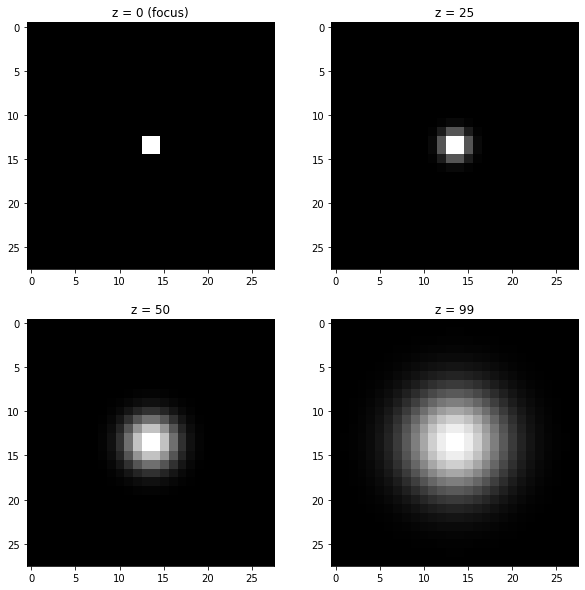

In [382]:
# Showing our incoherent point spread function at several depths
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.imshow(g_incoh[:,:,0],cmap = 'gray')
plt.title('z = 0 (focus)')
plt.subplot(2,2,2)
plt.imshow(g_incoh[:,:,25],cmap = 'gray')
plt.title('z = 25')
plt.subplot(2,2,3)
plt.imshow(g_incoh[:,:,50],cmap = 'gray')
plt.title('z = 50')
plt.subplot(2,2,4)
plt.imshow(g_incoh[:,:,99],cmap = 'gray')
plt.title('z = 99')

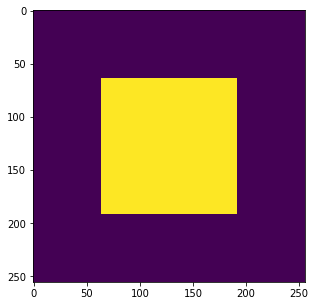

In [386]:
# Creating our 3D object (a square of ones 128x128x100)
obj = np.zeros((256,256,100))
obj[64:192,64:192,:] = 1

plt.figure(figsize=[5,5])
plt.imshow(obj[:,:,20])

## 3D Imaging Implementation

In [392]:
# Implementing the incoherent imaging by convolving the incoherent PSF with the 
# object at each plane / depth 0 to 100 wavelengths
img3D = np.zeros((256,256,100))
pbar3 = ProgressBar()

for z in pbar3(range(0,100)):
  img3D[:,:,z] = convolve2d(obj[:,:,z], g_incoh[:,:,z], 'same')
  img3D += img3D.max() *1E-5

100% (100 of 100) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


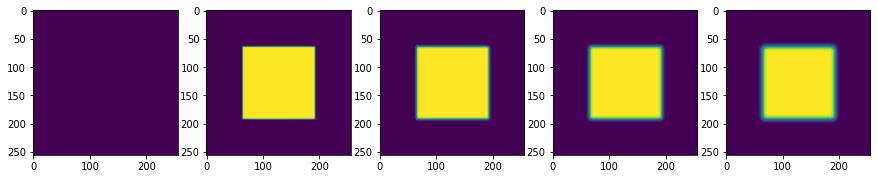

In [393]:
# Showing our results of imaging

# Plotting our results
plt.figure(figsize=[15,15])
plt.subplot(1,5,1)
plt.imshow(img3D[:,:,0])
plt.subplot(1,5,2)
plt.imshow(img3D[:,:,25])
plt.subplot(1,5,3)
plt.imshow(img3D[:,:,50])
plt.subplot(1,5,4)
plt.imshow(img3D[:,:,75])
plt.subplot(1,5,5)
plt.imshow(img3D[:,:,99])

# 2.) Deconvolution Methods
Here we will implement several methods to recover the underlying object which has been blurred by the PSF. We will add noise and compare results with the initial, unprocessed image. We perform these on the extreme case of 100 wavelength depth, where the image will be most blurred. 

## Richardson-Lucy Deconvolution

The first implementation below demonstrates Richardson-Lucy deconvolution on un-noisy images with three levels of iterations, to see how well the algorithm handles the image blur. Richardson-Lucy performs extremely well in this situation, almost eliminating any blur induced by the PSF. Unfortunately, this is unrealistic, as any imaging system will have some level of noise present. (It is important to note that RL may very well be proficient at handling noise, but in this specific implementation, it did not handle it well. This can be atributed to many factors such as syntax error, sampling, and necessary fine-tuning of iteration level.)

The second implementation demonstrates samples of the imaged object at 100 wavelengths for SNR levels of 1, 10, and 100 (top row), and the Richardson-Lucy Deconvolution estimation of the noisy objects (bottom row). We can see that the RL algorithm doesn't handle noise levels well in this case, and what we obtain are images with an extreme amount of artifacts. The reconstructed object is only recognizable when we scale / average the pixel itensities, but even still the artifacts apparent in the image contain higher signal than the actual object we are trying to image. 

Text(0.5, 1.0, 'RL 200 iterations')

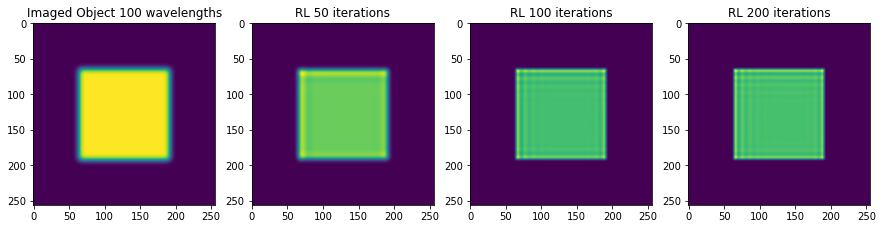

In [394]:
# Richardson-Lucy deconvolution on un-noised images
RL1 = restoration.richardson_lucy(img3D[:,:,99], g_incoh[:,:,99], iterations = 5)
RL2 = restoration.richardson_lucy(img3D[:,:,99], g_incoh[:,:,99], iterations = 100)
RL3 = restoration.richardson_lucy(img3D[:,:,99], g_incoh[:,:,99], iterations = 200)

plt.figure(figsize=[15,15])
plt.subplot(1,4,1)
plt.imshow(img3D[:,:,99])
plt.title('Imaged Object 100 wavelengths')
plt.subplot(1,4,2)
plt.imshow(RL1)
plt.title('RL 50 iterations')
plt.subplot(1,4,3)
plt.imshow(RL2)
plt.title('RL 100 iterations')
plt.subplot(1,4,4)
plt.imshow(RL3)
plt.title('RL 200 iterations')

Text(0.5, 1.0, 'RL, SNR = 100')

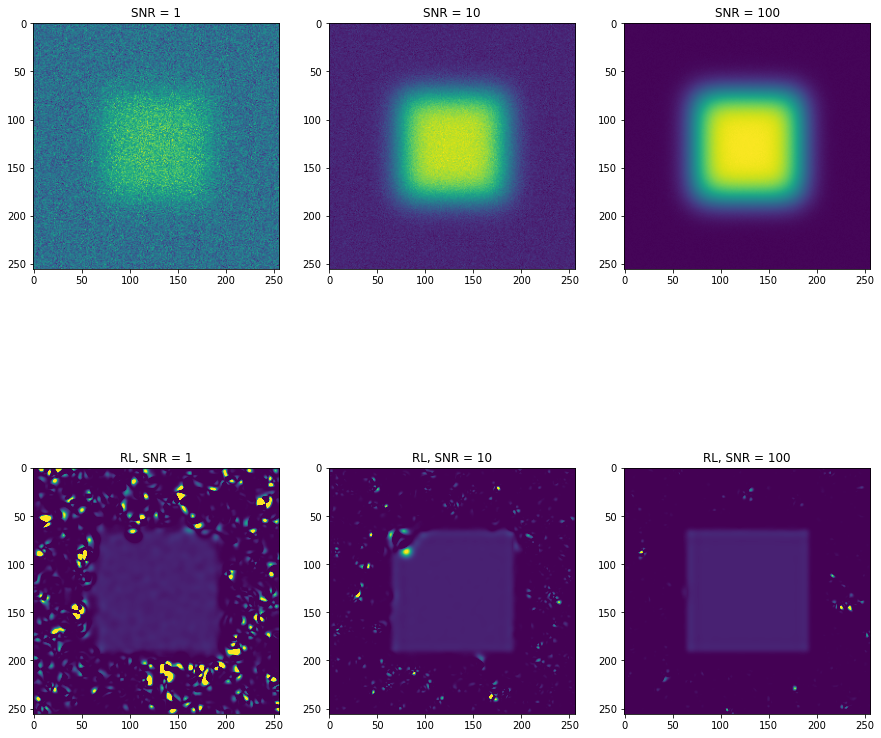

In [420]:
# Adding noise to the images
snr1 = 1
snr2 = 10
snr3 = 100
rng = np.random.default_rng()

img_noisy1 = img3D[:,:,99].copy()
img_noisy2 = img3D[:,:,99].copy()
img_noisy3 = img3D[:,:,99].copy()

img_noisy1 += img3D[:,:,99].std() * np.random.standard_normal(img3D[:,:,99].shape)/snr1
img_noisy2 += img3D[:,:,99].std() * np.random.standard_normal(img3D[:,:,99].shape)/snr2
img_noisy3 += img3D[:,:,99].std() * np.random.standard_normal(img3D[:,:,99].shape)/snr3

img4_RL1 = restoration.richardson_lucy(img_noisy1, g_incoh[:,:,99], iterations = 5)
img4_RL2 = restoration.richardson_lucy(img_noisy2, g_incoh[:,:,99], iterations = 10)
img4_RL3 = restoration.richardson_lucy(img_noisy3, g_incoh[:,:,99], iterations = 10)

plt.figure(figsize=[15,15])
plt.subplot(2,3,1)
plt.imshow(img4_noisy1)
plt.title('SNR = 1')
plt.subplot(2,3,2)
plt.imshow(img4_noisy2)
plt.title('SNR = 10')
plt.subplot(2,3,3)
plt.imshow(img4_noisy3)
plt.title('SNR = 100')
plt.subplot(2,3,4)
plt.imshow(img4_RL1, vmin = 0, vmax = 0.1)
plt.title('RL, SNR = 1')
plt.subplot(2,3,5)
plt.imshow(img4_RL2, vmin = 0, vmax = 0.1)
plt.title('RL, SNR = 10')
plt.subplot(2,3,6)
plt.imshow(img4_RL3, vmin = 0, vmax = 0.1)
plt.title('RL, SNR = 100')

## Weiner Filtering

The images shown below are the Wiener-filtered reconstructions of noisy image at 100 wavelengths of depth (noisy images shown in the RL exercise above). 

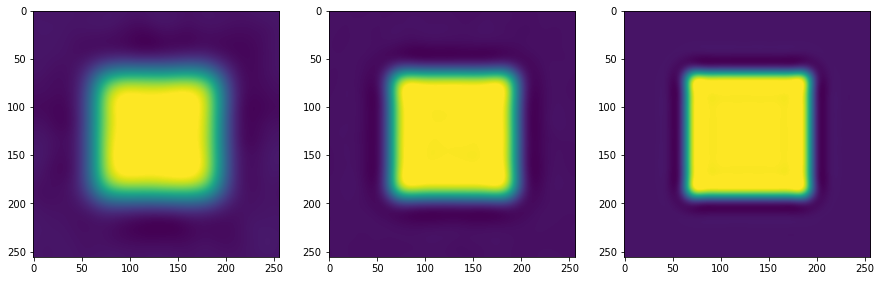

In [422]:
img4_W1 = restoration.wiener(img_noisy1, g_incoh[:,:,99], 1/snr1)
img4_W2 = restoration.wiener(img_noisy2, g_incoh[:,:,99], 1/snr2)
img4_W3 = restoration.wiener(img_noisy3, g_incoh[:,:,99], 1/snr3)

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.imshow(img4_W1)
plt.subplot(1,3,2)
plt.imshow(img4_W2)
plt.subplot(1,3,3)
plt.imshow(img4_W3)

## Total Variation Deconvolution

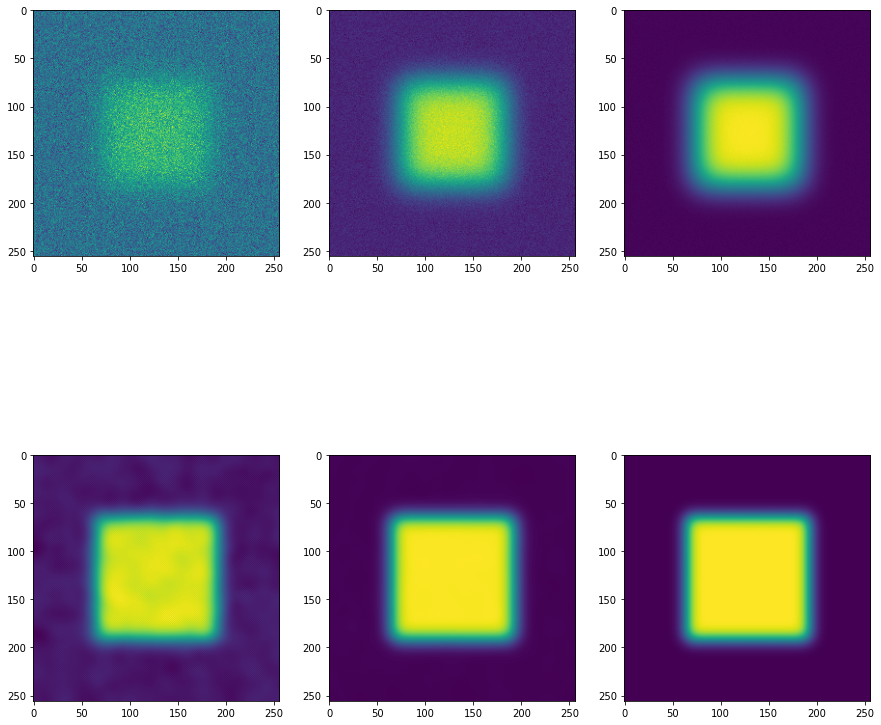

In [423]:
from skimage.restoration import denoise_tv_chambolle

img4_TV1 = denoise_tv_chambolle(img_noisy1, weight = 0.2)
img4_TV2 = denoise_tv_chambolle(img_noisy2, weight = 0.2)
img4_TV3 = denoise_tv_chambolle(img_noisy3, weight = 0.2)

plt.figure(figsize=[15,15])
plt.subplot(2,3,1)
plt.imshow(img4_noisy1)
plt.subplot(2,3,2)
plt.imshow(img4_noisy2)
plt.subplot(2,3,3)
plt.imshow(img4_noisy3)
plt.subplot(2,3,4)
plt.imshow(img4_TV1)
plt.subplot(2,3,5)
plt.imshow(img4_TV2)
plt.subplot(2,3,6)
plt.imshow(img4_TV3)

# 3.)  Neural Estimation of 3D Imaged Object

After examining the performance of the inverse algorithms above, we may also compare the performance of a neural network to deblur our 3D imaged object. Attempts are made below to do some deblurring prior to the network implementation, but results from these show that the algorithms blur the images more. This is perhaps due to the undersampled PSF or the simplicity of our object. As such, the reconstructions from Wiener, RL, or TV will not be used within the network, but rather just the noisy images of the 3D object. 

## Object and PSF Generation

256


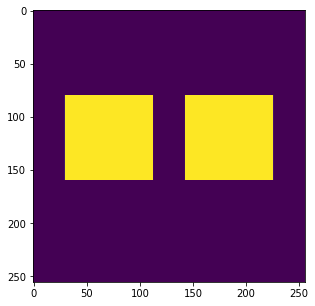

In [426]:
# Creating our Object
obj2 = np.zeros((256,256,100))
obj2[80:160,30:226:] = 1
obj2[:,113:143:] = 0

plt.figure(figsize=[5,5])
plt.imshow(obj2[:,:,20])

print(len(obj2))

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


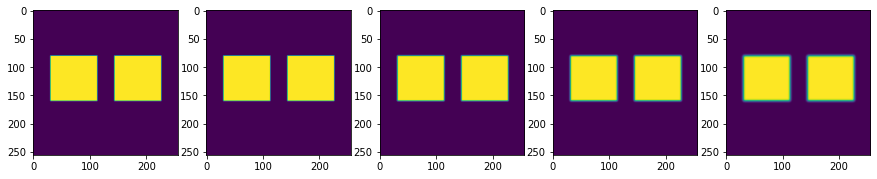

In [427]:
# Imaging our  object

# PSF
N = 28
x = np.linspace(-100, 100,N)
xx,yy = np.meshgrid(x,x)
rho = np.sqrt(xx**2 + yy**2)
w0 = 2
g_coh = np.zeros((N,N,100))
g_incoh = np.zeros((N,N,100))
pbar1 = ProgressBar()

for z in pbar1(range(0,100)):
  g_coh[:,:,z] = np.abs(g(rho, z, w0))
  g_incoh[:,:,z] = np.abs(g_coh[:,:,z])**2

# Implementing the incoherent imaging by convolving the incoherent PSF with the 
# object at each plane / depth 0 to 100 wavelengths
img3D = np.zeros((256,256,100))
pbar3 = ProgressBar()

for z in pbar3(range(0,100)):
  img3D[:,:,z] = convolve2d(obj2[:,:,z], g_incoh[:,:,z], 'same')

# Showing our results of imaging
img0 = img3D[:,:,0]
img1 = img3D[:,:,25]
img2 = img3D[:,:,50]
img3 = img3D[:,:,75]
img4 = img3D[:,:,99]

# Plotting our results
plt.figure(figsize=[15,15])
plt.subplot(1,5,1)
plt.imshow(img0)
plt.subplot(1,5,2)
plt.imshow(img1)
plt.subplot(1,5,3)
plt.imshow(img2)
plt.subplot(1,5,4)
plt.imshow(img3)
plt.subplot(1,5,5)
plt.imshow(img4)

## Denoising and Deblurring

The followimg implementations are attempts to denoise/deblur the images of our 3D object. The results from these methods will not be implemented into our neural network. 

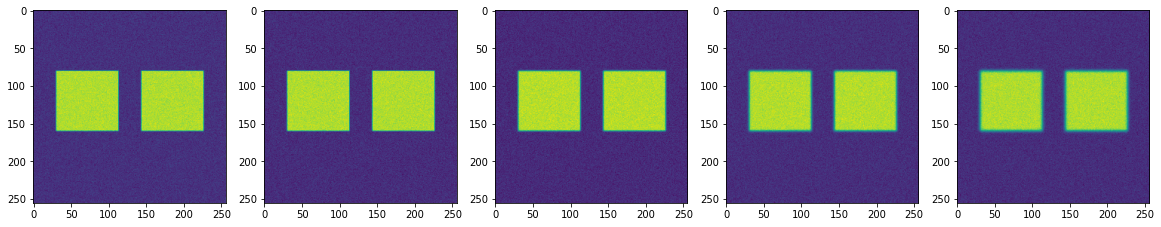

In [429]:
# Noisy objects
snr = 10
rng = np.random.default_rng()

obj_noisy = np.zeros((256,256,100))

for z in range(0,100):
  obj_noisy[:,:,z] = img3D[:,:,z].copy()
  obj_noisy[:,:,z] += img3D[:,:,z].std() * np.random.standard_normal(img3D[:,:,z].shape)/snr

plt.figure(figsize=[20,20])
plt.subplot(1,5,1)
plt.imshow(obj_noisy[:,:,0])
plt.subplot(1,5,2)
plt.imshow(obj_noisy[:,:,25])
plt.subplot(1,5,3)
plt.imshow(obj_noisy[:,:,50])
plt.subplot(1,5,4)
plt.imshow(obj_noisy[:,:,75])
plt.subplot(1,5,5)
plt.imshow(obj_noisy[:,:,99])

The following are results of using RL to deblur the images, which are not very desireable. We will instead utilize just the total variation deconvolution method to enhance the images. 

In [434]:
# Total Variation to reduce noise & RL to reduce blur
img_denoised = np.zeros((256,256,100))
img_corrected = np.zeros((256,256,100))
obj_noisy += obj_noisy.max() *1E-5
g_incoh += g_incoh.max() * 1E-5


for z in range(0,100):
  img_denoised[:,:,z] = denoise_tv_chambolle(obj_noisy[:,:,z], weight = 0.2)
  img_corrected[:,:,z] = restoration.richardson_lucy(img_denoised[:,:,z], g_incoh[:,:,z], iterations = 10)

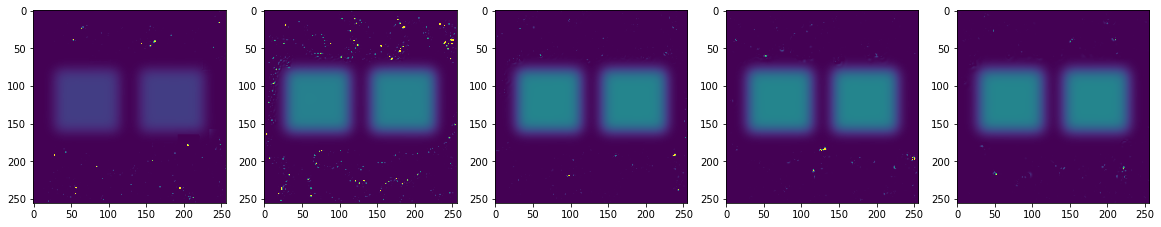

In [443]:
plt.figure(figsize=[20,20])
plt.subplot(1,5,1)
plt.imshow(img_corrected[:,:,10], vmin = 0, vmax = 0.0005)
plt.subplot(1,5,2)
plt.imshow(img_corrected[:,:,25], vmin = 0, vmax = 0.005)
plt.subplot(1,5,3)
plt.imshow(img_corrected[:,:,50], vmin = 0, vmax = 0.005)
plt.subplot(1,5,4)
plt.imshow(img_corrected[:,:,75], vmin = 0, vmax = 0.005)
plt.subplot(1,5,5)
plt.imshow(img_corrected[:,:,99], vmin = 0, vmax = 0.005)

In [ ]:
# Total Variation to reduce noise & Wiener to reduce blur
img_denoised = np.zeros((256,256,100))
img_corrected = np.zeros((256,256,100))
pbar2 = ProgressBar()

for z in pbar2(range(0,100)):
  img_denoised[:,:,z] = denoise_tv_chambolle(obj_noisy[:,:,z], weight = 0.1)
  img_corrected[:,:,z] = restoration.wiener(img_denoised[:,:,z], g_incoh[:,:,z], 1/snr)

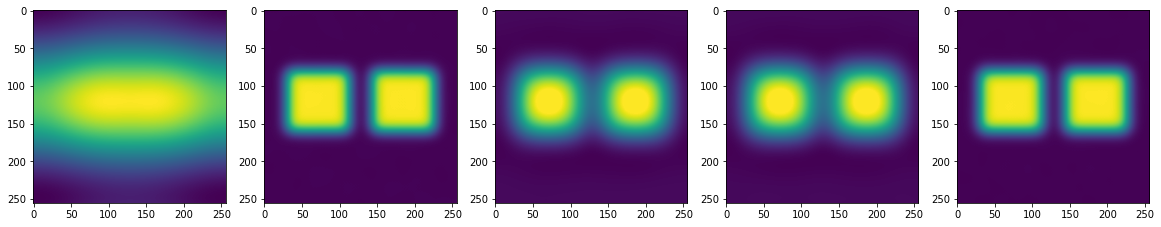

In [447]:
plt.figure(figsize=[20,20])
plt.subplot(1,5,1)
plt.imshow(img_corrected[:,:,10])
plt.subplot(1,5,2)
plt.imshow(img_corrected[:,:,25])
plt.subplot(1,5,3)
plt.imshow(img_corrected[:,:,50])
plt.subplot(1,5,4)
plt.imshow(img_corrected[:,:,75])
plt.subplot(1,5,5)
plt.imshow(img_corrected[:,:,99])

## Denoising / Deblurring Model

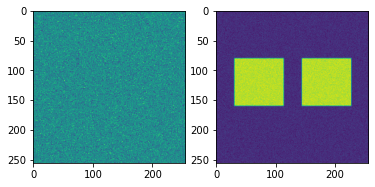

In [448]:
x_test = np.reshape(obj2, (100,256,256,1))
#x_test = x_test[:,:,:, np.newaxis]
x_train = np.reshape(obj2, (100,256,256,1))
#x_train = x_train[:,:,:,np.newaxis]
g_train = np.reshape(obj_noisy, (100,256,256,1))
#g_train = g_train[:,:,:,np.newaxis]
g_test = np.reshape(obj_noisy, (100,256,256,1))
#g_test = g_test[:,:,:,np.newaxis]

testing = np.reshape(g_test, (256,256,100,1))
plt.subplot(1,2,1)
plt.imshow(g_test[20,:,:,0])
plt.subplot(1,2,2)
plt.imshow(testing[:,:,20,0])


In [449]:
input_img = keras.Input(shape=(256, 256, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(input_img)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(input_img, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_113 (Conv2D)         (None, 256, 256, 32)      832       
                                                                 
 conv2d_114 (Conv2D)         (None, 128, 128, 32)      16416     
                                                                 
 conv2d_115 (Conv2D)         (None, 64, 64, 64)        18496     
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 128, 128, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 256, 256, 32)     18464     
 ranspose)                                                

In [450]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=14,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/14
1/1 [==============================] - 39s 39s/step - loss: 0.2026 - val_loss: 0.2020
Epoch 2/14
1/1 [==============================] - 33s 33s/step - loss: 0.2020 - val_loss: 0.2012
Epoch 3/14
1/1 [==============================] - 32s 32s/step - loss: 0.2012 - val_loss: 0.2003
Epoch 4/14
1/1 [==============================] - 32s 32s/step - loss: 0.2003 - val_loss: 0.1993
Epoch 5/14
1/1 [==============================] - 32s 32s/step - loss: 0.1993 - val_loss: 0.1983
Epoch 6/14
1/1 [==============================] - 32s 32s/step - loss: 0.1983 - val_loss: 0.1972
Epoch 7/14
1/1 [==============================] - 32s 32s/step - loss: 0.1972 - val_loss: 0.1959
Epoch 8/14
1/1 [==============================] - 32s 32s/step - loss: 0.1959 - val_loss: 0.1945
Epoch 9/14
1/1 [==============================] - 33s 33s/step - loss: 0.1945 - val_loss: 0.1929
Epoch 10/14
1/1 [==============================] - 33s 33s/step - loss: 0.1929 - val_loss: 0.1912
Epoch 11/14
1/1 [============

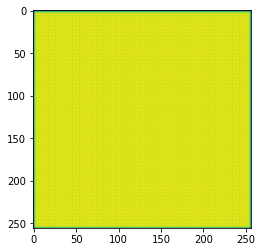

In [483]:
plt.imshow(autoencoder.predict(g_test[10:99,:,:,0])[0,:,:,0])

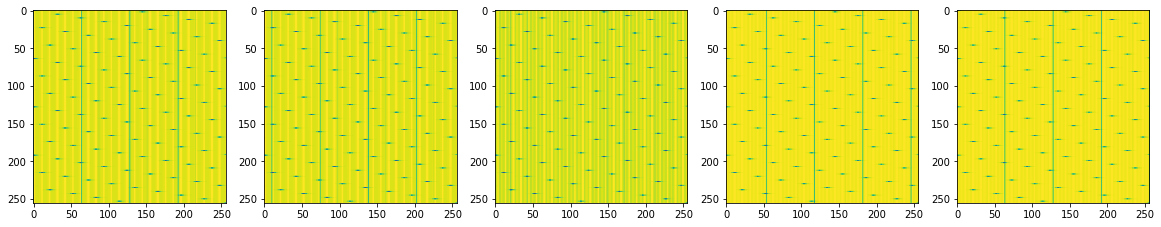

In [485]:
# Showing our results 


predicted = autoencoder.predict(g_test)
output = np.reshape(predicted,(256,256,100,1))

plt.figure(figsize=[20,20])
plt.subplot(1,5,1)
plt.imshow(output[:,:,1,0])
plt.subplot(1,5,2)
plt.imshow(output[:,:,25,0])
plt.subplot(1,5,3)
plt.imshow(output[:,:,50,0])
plt.subplot(1,5,4)
plt.imshow(output[:,:,75,0])
plt.subplot(1,5,5)
plt.imshow(output[:,:,99,0])


We can see here that our neural denoiser/deblurring model did not perform well. This performance is most likely due to how the data has been reshaped prior to, and during, the neural processing; there must be some disconnect between the inputs and outputs of the neural network. After *many* attempts at reshaping the data in various ways that would be accepted and processed by the network, still no solution was found. A larger dataset would assist in achieving better predictions nonetheless, as well as bettter resolution of our PSF. Given these results, we will go ahead and process the images using simply the Wiener and TV algorithms and estimate spatial resolution on those outputs. 

# 4.) Spatial Resolution Analysis

In this portion of the assignment, we create an object of two point sources a small distance away from each other. We will examine the cross section of pixels along x-y and between depths in z and estimate the spatial resolution of the acquired image. 

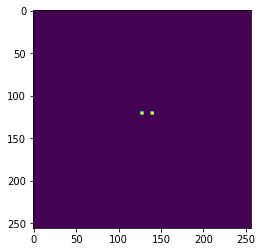

In [506]:
# Creating our object
obj = np.zeros((256,256,100))
obj[119:123, 126:130, :] = 1
obj[119:123,138:142,:] = 1

plt.imshow(obj[:,:,1])

In [507]:
# Imaging our  object

# PSF
N = 28
x = np.linspace(-100, 100,N)
xx,yy = np.meshgrid(x,x)
rho = np.sqrt(xx**2 + yy**2)
w0 = 1
g_coh = np.zeros((N,N,100))
g_incoh = np.zeros((N,N,100))
pbar1 = ProgressBar()

for z in pbar1(range(0,100)):
  g_coh[:,:,z] = np.abs(g(rho, z, w0))
  g_incoh[:,:,z] = np.abs(g_coh[:,:,z])**2

# Implementing the incoherent imaging by convolving the incoherent PSF with the 
# object at each plane / depth 0 to 100 wavelengths
img3D = np.zeros((256,256,100))
pbar3 = ProgressBar()

for z in pbar3(range(0,100)):
  img3D[:,:,z] = convolve2d(obj[:,:,z], g_incoh[:,:,z], 'same')


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


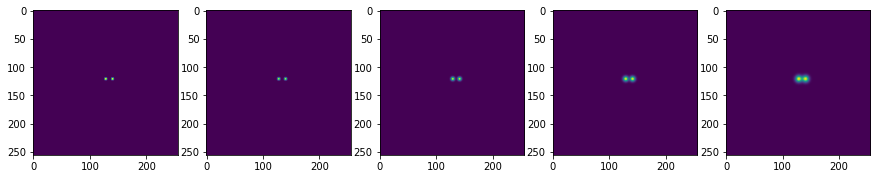

In [508]:
# Showing our results of imaging
#img0 = convolve2d(obj[:,:,0], g_incoh[:,:,0], 'same')
#img1 = convolve2d(obj[:,:,25], g_incoh[:,:,25], 'same')
#img2 = convolve2d(obj[:,:,50], g_incoh[:,:,50], 'same')
#img3 = convolve2d(obj[:,:,75], g_incoh[:,:,75], 'same')
#img4 = convolve2d(obj[:,:,99], g_incoh[:,:,99], 'same')

# Plotting our results
plt.figure(figsize=[15,15])
plt.subplot(1,5,1)
plt.imshow(img3D[:,:,0])
plt.subplot(1,5,2)
plt.imshow(img3D[:,:,25])
plt.subplot(1,5,3)
plt.imshow(img3D[:,:,50])
plt.subplot(1,5,4)
plt.imshow(img3D[:,:,75])
plt.subplot(1,5,5)
plt.imshow(img3D[:,:,99])

In [512]:
# Total Variation to reduce noise & RL to reduce blur
img_denoised = np.zeros((256,256,100))
img_corrected = np.zeros((256,256,100))
rng = np.random.default_rng()
obj_noisy = np.zeros((256,256,100))
obj_noisy += obj_noisy.max() * 1E-5
g_incoh += g_incoh.max() * 1E-5
snr = 100

for z in range(0,100):
  obj_noisy[:,:,z] = img3D[:,:,z].copy()
  obj_noisy[:,:,z] += img3D[:,:,z].std() * np.random.standard_normal(img3D[:,:,z].shape) * 1/snr

pbar = ProgressBar()
for z in pbar(range(0,100)):
  img_corrected[:,:,z] = restoration.richardson_lucy(obj_noisy[:,:,z], g_incoh[:,:,z], iterations = 50)



100% (100 of 100) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


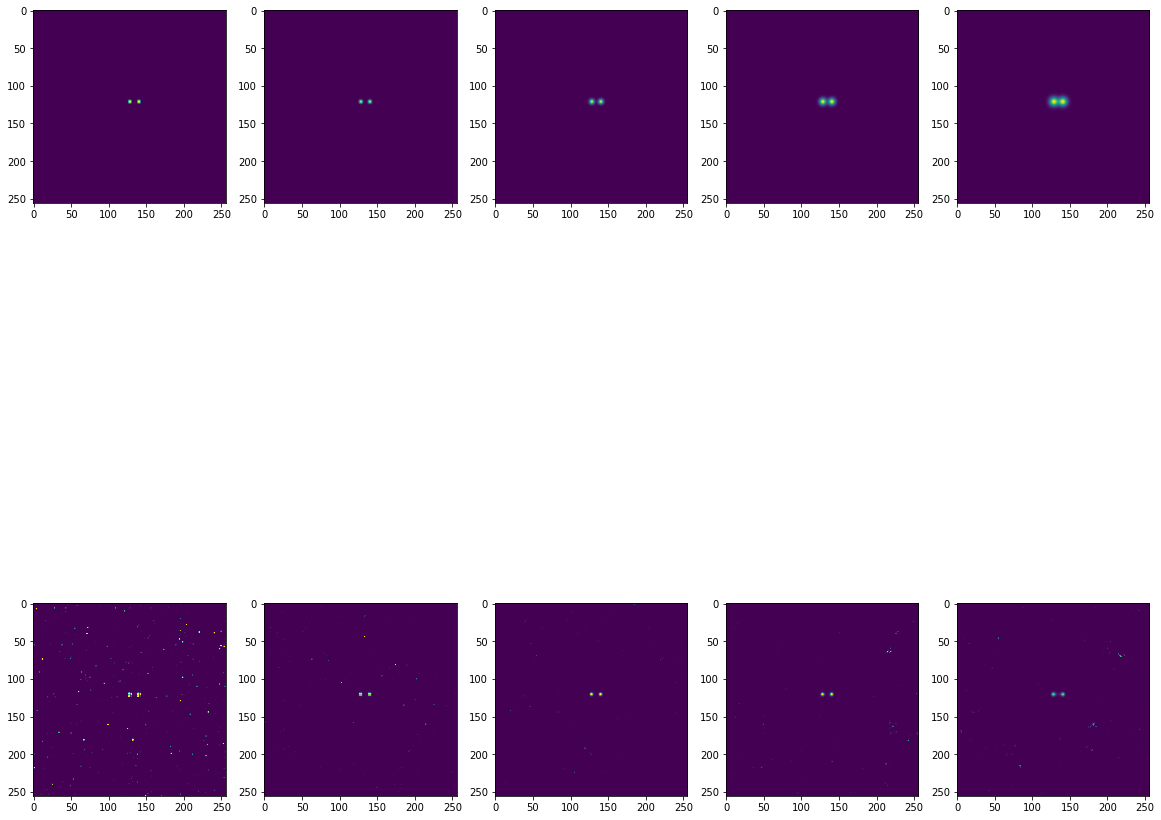

In [521]:
plt.figure(figsize=[20,20])
plt.subplot(2,5,1)
plt.imshow(obj_noisy[:,:,0])
plt.subplot(2,5,2)
plt.imshow(obj_noisy[:,:,25])
plt.subplot(2,5,3)
plt.imshow(obj_noisy[:,:,50])
plt.subplot(2,5,4)
plt.imshow(obj_noisy[:,:,75])
plt.subplot(2,5,5)
plt.imshow(obj_noisy[:,:,99])
plt.subplot(2,5,6)
plt.imshow(img_corrected[:,:,10], vmin = 0, vmax = 0.1)
plt.subplot(2,5,7)
plt.imshow(img_corrected[:,:,25], vmin = 0, vmax = 0.01)
plt.subplot(2,5,8)
plt.imshow(img_corrected[:,:,50], vmin = 0, vmax = 0.01)
plt.subplot(2,5,9)
plt.imshow(img_corrected[:,:,75], vmin = 0, vmax = 0.01)
plt.subplot(2,5,10)
plt.imshow(img_corrected[:,:,99], vmin = 0, vmax = 0.01)

Shown below are the cross section of intensities for the "corrected" images (top row) and the original images (bottom row).

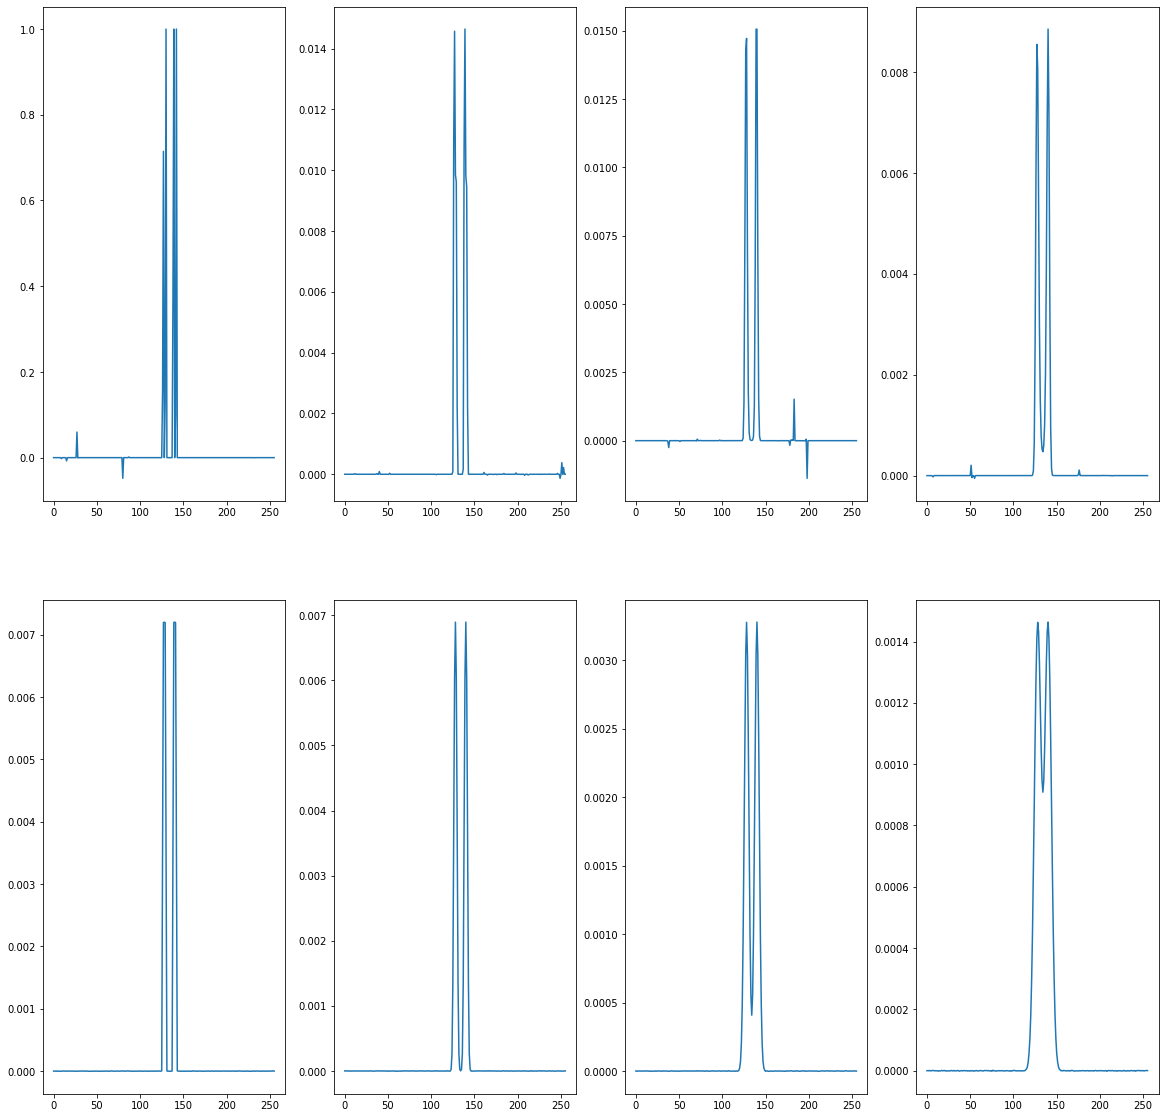

In [524]:
# Plotting cross secontion of images
plt.figure(figsize=[20,20])
plt.subplot(2,4,1)
plt.plot(img_corrected[120,:,10])
plt.subplot(2,4,2)
plt.plot(img_corrected[120,:,30])
plt.subplot(2,4,3)
plt.plot(img_corrected[120,:,60])
plt.subplot(2,4,4)
plt.plot(img_corrected[120,:,99])
plt.subplot(2,4,5)
plt.plot(obj_noisy[120,:,10])
plt.subplot(2,4,6)
plt.plot(obj_noisy[120,:,30])
plt.subplot(2,4,7)
plt.plot(obj_noisy[120,:,60])
plt.subplot(2,4,8)
plt.plot(obj_noisy[120,:,99])


# 5.) Discussion

It is apparent that the results of this exercise are less than adequate for what we are attempting to model. As a whole, three-dimensional imaging is a daunting task with many approaches available to tackle the problem. We have found that with various processing methods like total variation and Wiener filtering, it is possible to recover a cleaner, more defined original object that has been blurred by a system. As shown above, the Richardson-Lucy algorithm is able to recover the two point sources, and is able to recreate their definitive boundaries which is blurred by the original PSF. A working neural network, of course, would be able to extract these objects from the reconstructions and remove the obvious artifacts, making much-improved 3D reconstruction. While there are many variables at play in a real-world simulation (e.g. lens, bandwidth, object complexity, noise level, sampling), this is a sufficient demonstration of how one would simulate the imaging of a three-dimensional object and use computational imaging to improve and recover the information obtained. 